In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

%load_ext sql

%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb:///:memory:

In [36]:
%%sql

DROP TYPE IF EXISTS expansion;
CREATE TYPE expansion AS ENUM ('KTK', 'LCI', 'WOE', 'LTR', 'MOM', 'SIR', 'ONE', 'BRO', 'DMU', 'HBG', 'SNC', 'NEO', 'VOW', 'MID', 'AFR', 'STX', 'KHM');
DROP TYPE IF EXISTS event_type;
CREATE TYPE event_type AS ENUM ('PremierDraft', 'TradDraft', 'Sealed', 'TradSealed');
DROP TYPE IF EXISTS rank;
CREATE TYPE rank AS ENUM ('silver', 'bronze', 'None', 'none', 'gold', 'platinum', 'diamond', 'mythic');
DROP TYPE IF EXISTS color;
CREATE TYPE color AS ENUM ('RG', 'UBG', 'WUB', 'UBR', 'WUBG', 'BG', 'WG', 'WBG', 'WUBRG', 'UR', 'UB', 'WBR', 'WRG', 'None', 'BR', 'WUBR', 'G', 'WR', 'W', 'WU', 'WB', 'WUR', 'WUG', 'WBRG', 'BRG', 'U', 'URG', 'UBRG', 'UG', 'B', 'R', 'WURG');

,Success


In [49]:
%%sql

DROP TABLE IF EXISTS game;

# https://www.17lands.com/history/<draft_id>/<match_number - 1>/<game_number - 1>
CREATE TABLE game (
    expansion expansion NOT NULL,
    event_type event_type NOT NULL,
    draft_id VARCHAR NOT NULL,
    draft_time TIMESTAMP_S NOT NULL,
    build_index TINYINT NOT NULL,
    match_number TINYINT NOT NULL,
    game_number TINYINT NOT NULL,
    rank rank,
    opp_rank rank,
    main_colors color,
    splash_colors color,
    on_play BOOLEAN NOT NULL,
    num_mulligans TINYINT NOT NULL,
    opp_num_mulligans TINYINT NOT NULL,
    opp_colors color,
    num_turns TINYINT NOT NULL,
    won BOOLEAN NOT NULL,
    user_n_games_bucket INTEGER NOT NULL,
    user_game_win_rate_bucket DOUBLE,
)

,Success


In [50]:
%%sql

INSERT INTO
    game
BY NAME
SELECT
    expansion, event_type, draft_id, draft_time, build_index, match_number, game_number, rank, opp_rank, main_colors, splash_colors, on_play, num_mulligans, opp_num_mulligans, opp_colors, num_turns, won, user_n_games_bucket, user_game_win_rate_bucket
FROM
    # 'https://17lands-public.s3.amazonaws.com/analysis_data/game_data/game_data_public.BRO.PremierDraft.csv.gz'
    'C:/Users/zhang/Downloads/game_data_public.BRO.PremierDraft.csv.gz'

,Success


In [52]:
%%sql

# DROP INDEX IF EXISTS game_draft_match_game;
# CREATE UNIQUE INDEX game_draft_match_game ON game (draft_id, match_number, game_number);

DROP INDEX IF EXISTS game_draft;
CREATE INDEX game_draft ON game (draft_id);

DROP INDEX IF EXISTS game_rank;
CREATE INDEX game_rank ON game (rank);

DROP INDEX IF EXISTS game_main_colors;
CREATE INDEX game_main_colors ON game (main_colors);

DROP INDEX IF EXISTS game_splash_colors;
CREATE INDEX game_splash_colors ON game (splash_colors);

DROP INDEX IF EXISTS game_on_play;
CREATE INDEX game_on_play ON game (on_play);

DROP INDEX IF EXISTS game_user_n_games_bucket;
CREATE INDEX game_user_n_games_bucket ON game (user_n_games_bucket);

DROP INDEX IF EXISTS game_user_win_rate_bucket;
CREATE INDEX game_user_win_rate_bucket ON game (user_game_win_rate_bucket);

,Success


In [53]:
%%sql

DROP TABLE IF EXISTS draft;

# https://www.17lands.com/history/<draft_id>/<match_number - 1>/<game_number - 1>
CREATE TABLE draft (
    expansion expansion NOT NULL,
    event_type event_type NOT NULL,
    draft_id VARCHAR NOT NULL,
    draft_time TIMESTAMP_S NOT NULL,
    rank rank,
    
    event_match_wins TINYINT NOT NULL,
    event_match_losses TINYINT NOT NULL,
    
    pack_number TINYINT NOT NULL,
    pick_number TINYINT NOT NULL,

    pick VARCHAR NOT NULL,

    # the number of games the user played with the picked card in their maindeck, divided by the total number of games the user played (with that draft pool).
    pick_maindeck_rate DOUBLE NOT NULL,
    # the number of games the user played with the picked card in their sideboard, divided by the total number of games the user played (with that draft pool).
    pick_sideboard_in_rate DOUBLE NOT NULL,
    
    user_n_games_bucket INTEGER NOT NULL,
    user_game_win_rate_bucket DOUBLE
)

,Success


In [54]:
%%sql

INSERT INTO
    draft
BY NAME
SELECT
    expansion,
    event_type,
    draft_id,
    draft_time,
    rank,
    event_match_wins,
    event_match_losses,
    pack_number,
    pick_number,
    pick,
    pick_maindeck_rate,
    pick_sideboard_in_rate,
    user_n_games_bucket,
    user_game_win_rate_bucket,
FROM
    # 'https://17lands-public.s3.amazonaws.com/analysis_data/draft_data/draft_data_public.BRO.PremierDraft.csv.gz'
    'C:/Users/zhang/Downloads/draft_data_public.BRO.PremierDraft.csv.gz'

,Success


In [55]:
%%sql

DROP INDEX IF EXISTS draft_draft_pack_pick;
CREATE UNIQUE INDEX draft_draft_pack_pick ON draft (draft_id, pack_number, pick_number);

DROP INDEX IF EXISTS draft_draft;
CREATE INDEX draft_draft ON draft (draft_id);

DROP INDEX IF EXISTS draft_rank;
CREATE INDEX draft_rank ON draft (rank);

DROP INDEX IF EXISTS draft_user_n_games_bucket;
CREATE INDEX draft_user_n_games_bucket ON draft (user_n_games_bucket);

DROP INDEX IF EXISTS draft_user_win_rate_bucket;
CREATE INDEX draft_user_win_rate_bucket ON draft (user_game_win_rate_bucket);

,Success


In [56]:
import requests

response = requests.get('https://api.scryfall.com/bulk-data/oracle-cards')
response.raise_for_status()
scryfall_oracle_cards_download_uri = response.json()['download_uri']
del response

scryfall_oracle_cards_download_uri

'https://data.scryfall.io/oracle-cards/oracle-cards-20240114100126.json'

In [57]:
%%sql

DROP TABLE IF EXISTS scryfall_oracle_cards;
# CREATE TABLE scryfall_oracle_cards AS FROM read_json_auto('{{ scryfall_oracle_cards_download_uri }}')
CREATE TABLE scryfall_oracle_cards AS FROM read_json_auto('C:/Users/zhang/Downloads/oracle-cards-20240109100132.json')

,Success


In [58]:
%%sql

DROP INDEX IF EXISTS card_id;
CREATE UNIQUE INDEX card_id ON scryfall_oracle_cards (id);

DROP INDEX IF EXISTS card_name;
CREATE INDEX card_name ON scryfall_oracle_cards (name);

DROP INDEX IF EXISTS card_set;
CREATE INDEX card_set ON scryfall_oracle_cards (set);

,Success


In [64]:
import scipy
from statsmodels.stats.weightstats import DescrStatsW

user_game_win_rates = %sql SELECT user_game_win_rate_bucket, COUNT(*) AS count FROM game WHERE user_game_win_rate_bucket IS NOT NULL GROUP BY user_game_win_rate_bucket ORDER BY user_game_win_rate_bucket
user_n_games = %sql SELECT user_n_games_bucket, COUNT(*) AS count FROM game WHERE user_n_games_bucket IS NOT NULL GROUP BY user_n_games_bucket ORDER BY user_n_games_bucket

# TODO(shuaizhang): test if the distribution is normal

weighted_user_game_win_rates = DescrStatsW(user_game_win_rates['user_game_win_rate_bucket'], weights=user_game_win_rates['count'], ddof=0)
user_game_win_rate_threshold = weighted_user_game_win_rates.mean

weighted_user_n_games = DescrStatsW(user_n_games['user_n_games_bucket'], weights=user_n_games['count'], ddof=0)
user_n_games_threshold = weighted_user_n_games.mean

print(f"user_game_win_rate_threshold = {user_game_win_rate_threshold}, user_n_games_threshold = {user_n_games_threshold}")

user_game_win_rate_threshold = 0.5448437523037228, user_n_games_threshold = 92.06083038774882


<Axes: title={'center': 'Main Colors Distribution'}, ylabel='count'>

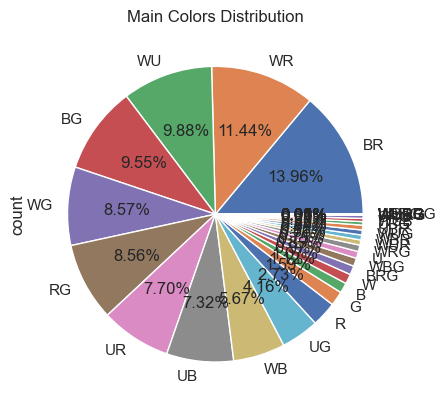

In [74]:
top_game = %sql SELECT main_colors, COUNT(*) AS count FROM game WHERE user_game_win_rate_bucket >= {{ user_game_win_rate_threshold }} AND user_n_games_bucket >= {{ user_n_games_threshold }} AND won = True GROUP BY main_colors ORDER BY count DESC
top_game.set_index('main_colors', inplace=True)
top_game.plot.pie(y='count', autopct='%.2f%%', title='Main Colors Distribution', legend=False)

TODO: Need to think Bayesian prior probability

M/R : UC : C = 1 : 3 : 10

LCI has 22 M and 64 R

In [65]:
%%sql priority_picks_df<<

WITH pick_counts AS(
    SELECT main_colors, pick, COUNT(*) AS count
    FROM draft d
    JOIN game g
    USING (draft_id)
    WHERE
        g.user_n_games_bucket >= {{ user_n_games_threshold }}
        AND g.user_game_win_rate_bucket >= {{ user_game_win_rate_threshold }}
        AND won = TRUE
        AND length(main_colors) = 2
        AND pick_number < 2
        AND pick_maindeck_rate = 1
    GROUP BY
        main_colors,
        pick
)
SELECT main_colors, pick, count
FROM pick_counts c1
WHERE
    count IN (
        SELECT count
        FROM pick_counts c2
        WHERE c2.main_colors = c1.main_colors
        ORDER BY count DESC
        # LIMIT 15
    )
ORDER BY main_colors, count DESC, pick

In [66]:
%%sql result_df<<

WITH pick_counts AS(
    SELECT main_colors, pick, COUNT(*) AS count
    FROM draft d
    JOIN game g
    USING (draft_id)
    WHERE
        g.user_n_games_bucket >= {{ user_n_games_threshold }}
        AND g.user_game_win_rate_bucket >= {{ user_game_win_rate_threshold }}
        AND won = TRUE
        AND length(main_colors) = 2
        AND (
            (pack_number = 0 AND pick_number < 5)
            OR (pack_number = 1 AND pick_number < 3)
            OR (pack_number = 2 AND pick_number < 3)
        )
        AND pick_maindeck_rate = 1
        # AND main_colors NOT IN ('UG', 'WB', 'BR', 'UB')
    GROUP BY
        main_colors,
        pick
)
SELECT main_colors, pick, count
FROM pick_counts c1
WHERE
    count IN (
        SELECT count
        FROM pick_counts c2
        WHERE c2.main_colors = c1.main_colors
        ORDER BY count DESC
        LIMIT 15
    )
    # AND main_colors NOT IN ('UG', 'WB', 'BR', 'UB')
ORDER BY main_colors, count DESC, pick

In [67]:
%%sql top_cards_df<<

SELECT p.pick, percentile, rarity, scryfall_uri, image_uris.large FROM (
    SELECT
        pick, percent_rank() OVER (ORDER BY SUM(count)) AS percentile
    FROM result_df
    GROUP BY pick
) AS p
JOIN scryfall_oracle_cards c
ON
    p.pick = c.name
    AND c.set = 'bro'
    AND list_contains(games, 'arena')
    AND set_type <> 'promo'
    AND digital = False
    AND promo_types IS NULL
ORDER BY percentile DESC

In [77]:
from IPython.display import display, HTML, Image

def url_to_image_html(path):
    return f'<a href="{path}"><img src="{path}" style="max-height:124px;"/>'

def url_website_html(row):
    return f'<a href="{row["scryfall_uri"]}">{row["pick"]}</a>'

formatters = {
    'large': url_to_image_html,
}

top_cards_df_formatted = top_cards_df.copy()

from IPython.utils import io

with io.capture_output() as _:
    top_cards_df_formatted["pick"] = top_cards_df.apply(url_website_html, axis=1)
    top_cards_df_formatted.drop(columns=["scryfall_uri"], inplace=True)

display(HTML(top_cards_df_formatted.loc[top_cards_df_formatted['rarity'] == 'common'].head(20).to_html(render_links=True, escape=False, float_format=lambda x: '%10.2f' % x, formatters=formatters)))
display(HTML(top_cards_df_formatted.loc[top_cards_df_formatted['rarity'] == 'uncommon'].head(10).to_html(render_links=True, escape=False, float_format=lambda x: '%10.2f' % x, formatters=formatters)))
display(HTML(top_cards_df_formatted.loc[top_cards_df_formatted['rarity'] == 'rare'].head(5).to_html(render_links=True, escape=False, float_format=lambda x: '%10.2f' % x, formatters=formatters)))
display(HTML(top_cards_df_formatted.loc[top_cards_df_formatted['rarity'] == 'mythic'].head(5).to_html(render_links=True, escape=False, float_format=lambda x: '%10.2f' % x, formatters=formatters)))

,pick,percentile,rarity,large
0,Excavation Explosion,1.00,common,
1,Overwhelming Remorse,0.98,common,
2,Scrapwork Mutt,0.96,common,
3,Scrapwork Cohort,0.94,common,
4,Prison Sentence,0.92,common,
5,Argothian Opportunist,0.91,common,
7,Disfigure,0.87,common,
8,Penregon Strongbull,0.85,common,
9,Airlift Chaplain,0.83,common,
11,Ambush Paratrooper,0.79,common,


,pick,percentile,rarity,large
6,Horned Stoneseeker,0.89,uncommon,
10,Obliterating Bolt,0.81,uncommon,
12,Static Net,0.77,uncommon,
13,Giant Cindermaw,0.75,uncommon,
17,Recruitment Officer,0.68,uncommon,
18,Thopter Mechanic,0.66,uncommon,
19,Zephyr Sentinel,0.64,uncommon,
20,Ashnod's Harvester,0.60,uncommon,
25,Mask of the Jadecrafter,0.51,uncommon,
26,Junkyard Genius,0.49,uncommon,


,pick,percentile,rarity,large
52,Titania's Command,0.00,rare,


,pick,percentile,rarity,large


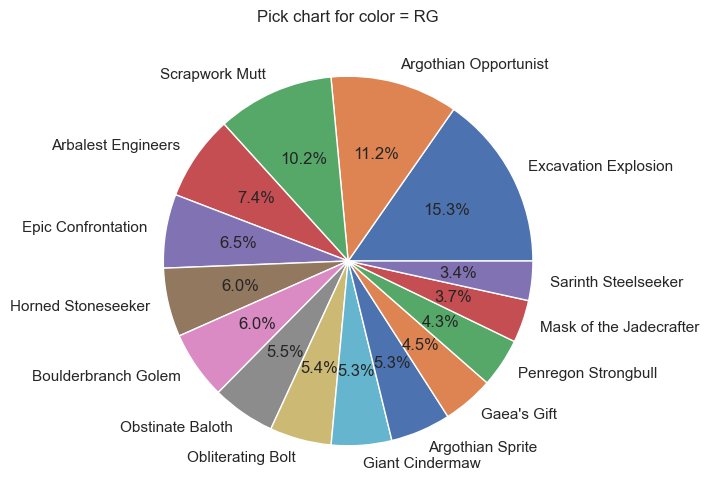

,pick,percentile,rarity,image
0,Excavation Explosion,1.00,common,
1,Argothian Opportunist,0.93,common,
2,Scrapwork Mutt,0.86,common,
3,Arbalest Engineers,0.79,uncommon,
4,Epic Confrontation,0.71,common,
5,Horned Stoneseeker,0.64,uncommon,
6,Boulderbranch Golem,0.57,common,
7,Obstinate Baloth,0.50,uncommon,
8,Obliterating Bolt,0.43,uncommon,
9,Giant Cindermaw,0.36,uncommon,


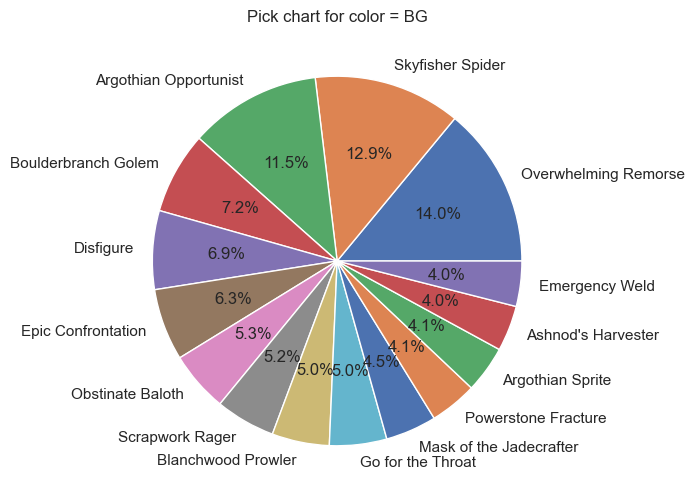

,pick,percentile,rarity,image
0,Overwhelming Remorse,1.00,common,
1,Skyfisher Spider,0.93,uncommon,
2,Argothian Opportunist,0.86,common,
3,Boulderbranch Golem,0.79,common,
4,Disfigure,0.71,common,
5,Epic Confrontation,0.64,common,
6,Obstinate Baloth,0.57,uncommon,
7,Scrapwork Rager,0.50,common,
8,Blanchwood Prowler,0.43,common,
9,Mask of the Jadecrafter,0.29,uncommon,


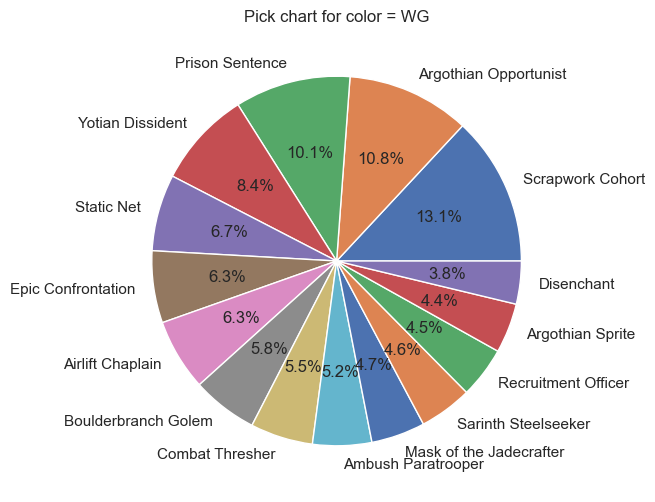

,pick,percentile,rarity,image
0,Scrapwork Cohort,1.00,common,
1,Argothian Opportunist,0.93,common,
2,Prison Sentence,0.86,common,
3,Yotian Dissident,0.79,uncommon,
4,Static Net,0.71,uncommon,
5,Epic Confrontation,0.64,common,
6,Airlift Chaplain,0.57,common,
7,Boulderbranch Golem,0.50,common,
8,Combat Thresher,0.43,uncommon,
9,Ambush Paratrooper,0.36,common,


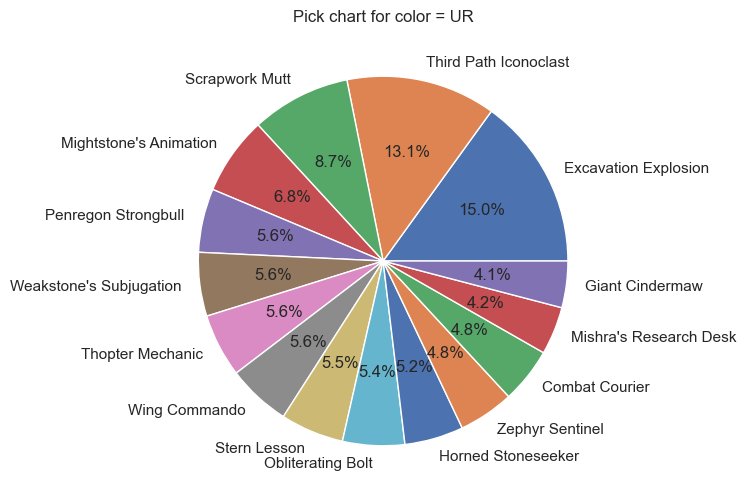

,pick,percentile,rarity,image
0,Excavation Explosion,1.00,common,
1,Third Path Iconoclast,0.93,uncommon,
2,Scrapwork Mutt,0.86,common,
3,Mightstone's Animation,0.79,common,
4,Weakstone's Subjugation,0.64,common,
5,Penregon Strongbull,0.64,common,
6,Wing Commando,0.50,common,
7,Thopter Mechanic,0.50,uncommon,
8,Stern Lesson,0.43,common,
9,Obliterating Bolt,0.36,uncommon,


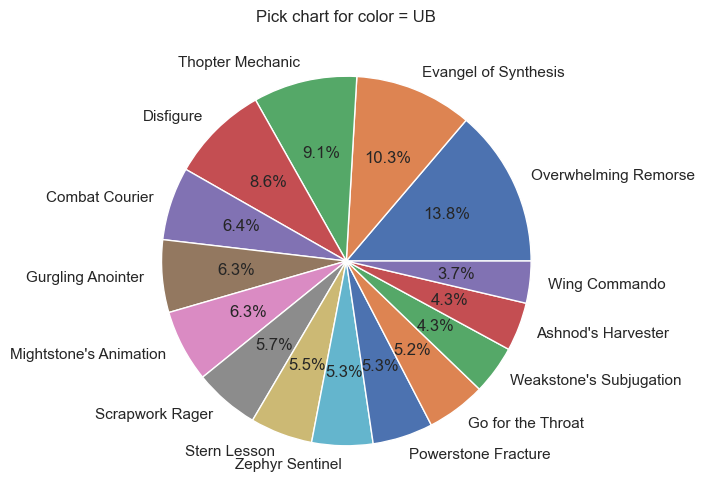

,pick,percentile,rarity,image
0,Overwhelming Remorse,1.00,common,
1,Evangel of Synthesis,0.93,uncommon,
2,Thopter Mechanic,0.86,uncommon,
3,Disfigure,0.79,common,
4,Combat Courier,0.71,common,
5,Gurgling Anointer,0.64,uncommon,
6,Mightstone's Animation,0.57,common,
7,Scrapwork Rager,0.50,common,
8,Stern Lesson,0.43,common,
9,Zephyr Sentinel,0.36,uncommon,


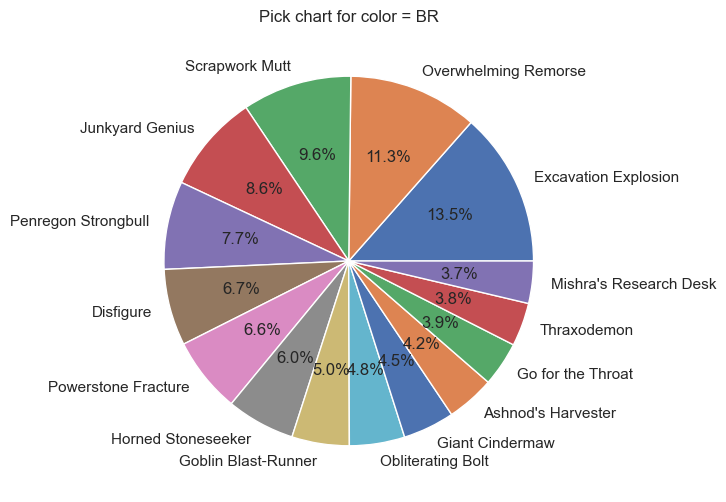

,pick,percentile,rarity,image
0,Excavation Explosion,1.00,common,
1,Overwhelming Remorse,0.93,common,
2,Scrapwork Mutt,0.86,common,
3,Junkyard Genius,0.79,uncommon,
4,Penregon Strongbull,0.71,common,
5,Disfigure,0.64,common,
6,Powerstone Fracture,0.57,common,
7,Horned Stoneseeker,0.50,uncommon,
8,Goblin Blast-Runner,0.43,common,
9,Obliterating Bolt,0.36,uncommon,


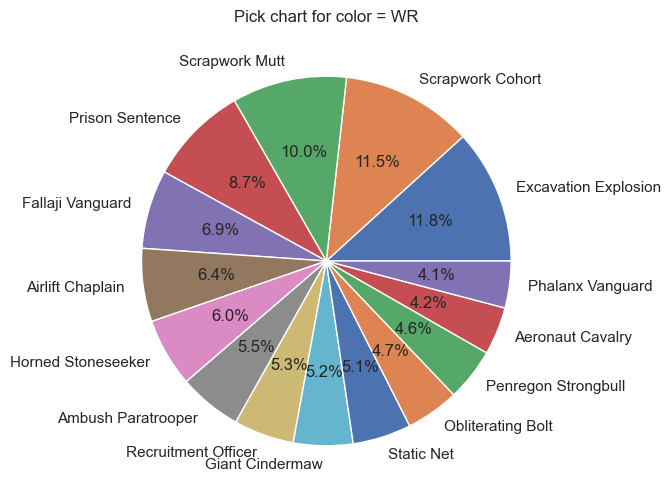

,pick,percentile,rarity,image
0,Excavation Explosion,1.00,common,
1,Scrapwork Cohort,0.93,common,
2,Scrapwork Mutt,0.86,common,
3,Prison Sentence,0.79,common,
4,Fallaji Vanguard,0.71,uncommon,
5,Airlift Chaplain,0.64,common,
6,Horned Stoneseeker,0.57,uncommon,
7,Ambush Paratrooper,0.50,common,
8,Recruitment Officer,0.43,uncommon,
9,Giant Cindermaw,0.36,uncommon,


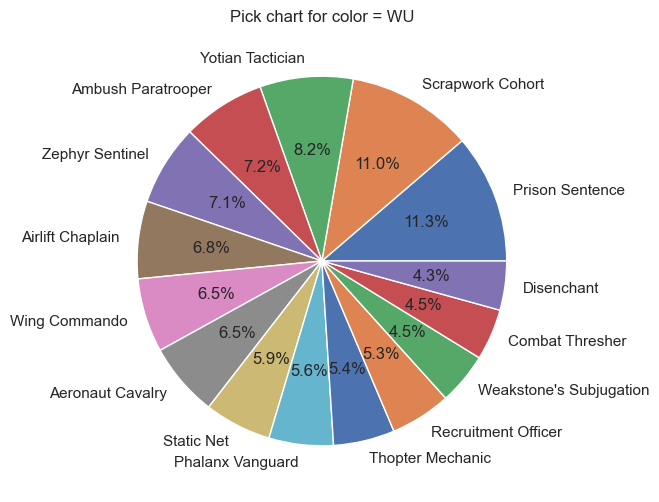

,pick,percentile,rarity,image
0,Prison Sentence,1.00,common,
1,Scrapwork Cohort,0.93,common,
2,Yotian Tactician,0.86,uncommon,
3,Ambush Paratrooper,0.79,common,
4,Zephyr Sentinel,0.71,uncommon,
5,Airlift Chaplain,0.64,common,
6,Wing Commando,0.57,common,
7,Aeronaut Cavalry,0.50,common,
8,Static Net,0.43,uncommon,
9,Phalanx Vanguard,0.36,common,


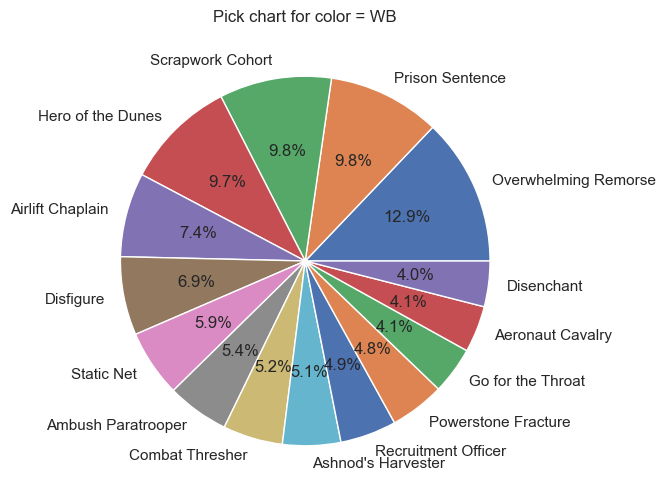

,pick,percentile,rarity,image
0,Overwhelming Remorse,1.00,common,
1,Prison Sentence,0.93,common,
2,Scrapwork Cohort,0.86,common,
3,Hero of the Dunes,0.79,uncommon,
4,Airlift Chaplain,0.71,common,
5,Disfigure,0.64,common,
6,Static Net,0.57,uncommon,
7,Ambush Paratrooper,0.50,common,
8,Combat Thresher,0.43,uncommon,
9,Ashnod's Harvester,0.36,uncommon,


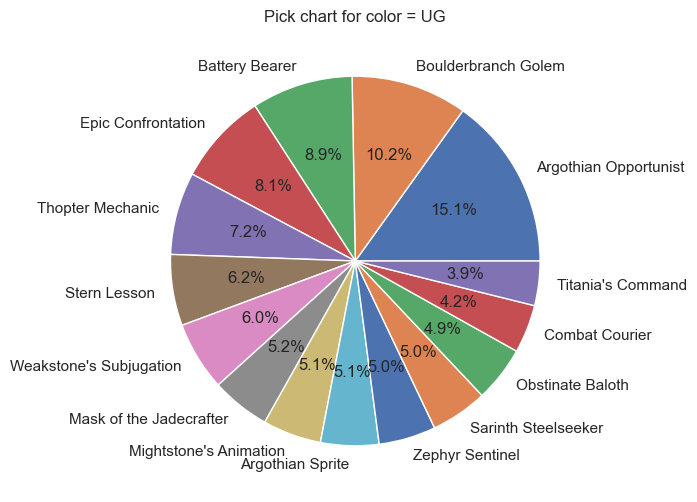

,pick,percentile,rarity,image
0,Argothian Opportunist,1.00,common,
1,Boulderbranch Golem,0.93,common,
2,Battery Bearer,0.86,uncommon,
3,Epic Confrontation,0.79,common,
4,Thopter Mechanic,0.71,uncommon,
5,Stern Lesson,0.64,common,
6,Weakstone's Subjugation,0.57,common,
7,Mask of the Jadecrafter,0.50,uncommon,
8,Mightstone's Animation,0.43,common,
9,Argothian Sprite,0.36,common,


In [72]:
from IPython.display import display, HTML, Image
from IPython.utils import io

def url_to_image_html(path):
    return f'<a href="{path}"><img src="{path}" style="max-height:124px;"/>'

def url_website_html(row):
    return f'<a href="{row["scryfall_uri"]}">{row["pick"]}</a>'

result = result_df.copy()
for main_color in result["main_colors"].unique():
    filtered_data = result[result["main_colors"] == main_color].copy()
    plt.figure(figsize=(6, 6))
    plt.pie(filtered_data["count"], labels=filtered_data["pick"], autopct="%1.1f%%")
    plt.title(f"Pick chart for color = {main_color}")
    plt.show()
    query = """
SELECT p.pick, percentile, rarity, scryfall_uri, image_uris.large FROM (
    SELECT
        pick, percent_rank() OVER (ORDER BY SUM(count)) AS percentile
    FROM filtered_data
    GROUP BY pick
) AS p
JOIN scryfall_oracle_cards c
ON
    p.pick = c.name
    AND c.set = 'bro'
    AND list_contains(games, 'arena')
    AND set_type <> 'promo'
    AND digital = False
    AND promo_types IS NULL
ORDER BY percentile DESC"""
    tmp_result = %sql {{ query }}

    with io.capture_output() as _:
        tmp_result["pick"] = tmp_result.apply(url_website_html, axis=1)
        tmp_result.drop(columns=["scryfall_uri"], inplace=True)
        tmp_result.rename(columns={"large": "image"}, inplace=True)

    display(HTML(f"<H3>Top colors for {main_color}</H3>" + tmp_result.to_html(render_links=True, escape=False, float_format=lambda x: '%10.2f' % x, formatters=dict(image=url_to_image_html))))